In [1]:
import gzip
import importlib
import json
from pathlib import Path

import models
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import train_DeepChIP as tDC
import utils
from Bio import SeqIO

In [2]:
model_name = "model_siameseinception3"
config = json.load(open(f"/home/alex/ChIP_ENCODE/{model_name}/config.json"))
print(config)

{'dataset_dir': '/home/alex/shared_folder/ChIP_ENCODE/paired_sharded_dataset', 'output_dir': '/home/alex/ChIP_ENCODE/model_siameseinception3', 'architecture': 'SiameseInceptionNetwork', 'paired': True, 'strand': 'both', 'learn_rate': 0.001, 'epochs': 100, 'batch_size': 1024, 'max_train': 1024, 'max_valid': 256, 'num_workers': 4, 'balance': False, 'loss_fn': 'BCElogits', 'optimizer_ctor': 'adam', 'patience': 10, 'verbose': True, 'device': 'cuda', 'timestamp': '2024-11-15 16:52:01.617200', 'machine': '7196jm23lnx2'}


In [3]:
dataset_train = tDC.DatasetFromFiles(
    config["dataset_dir"],
    split="train",
    strand=config["strand"],
    paired=config["paired"],
)
dataset_valid = tDC.DatasetFromFiles(
    config["dataset_dir"],
    split="valid",
    strand=config["strand"],
    paired=config["paired"],
)
dataset_test = tDC.DatasetFromFiles(
    config["dataset_dir"],
    split="test",
    strand=config["strand"],
    paired=config["paired"],
)

In [4]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"]
)
dataloader_valid = DataLoader(
    dataset_valid,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"]
)
dataloader_test = DataLoader(
    dataset_test,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"]
)

In [11]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")
model = models.ARCHITECTURES[config["architecture"]]().to(device)
model.load_state_dict(torch.load(f"/home/alex/ChIP_ENCODE/{model_name}/model_state.pt"))

Using device cuda


<All keys matched successfully>

In [6]:
def predict(model, dataloader, device, paired=True):
    res = []
    with torch.no_grad():
        for X, *_ in dataloader:
            if paired:
                X1, X2 = X
                X1, X2 = X1.to(device), X2.to(device)
                logits = model(X1, X2)
            else:
                X = X.to(device)
                logits = model(X)
            res.append(torch.sigmoid(logits).cpu())
    return torch.concat(res).squeeze()

In [7]:
preds = predict(model, dataloader_valid, device)

/home/alex/miniconda3/envs/flamingo-3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


In [13]:
preds[:10]

tensor([0.6140, 0.2398, 0.5610, 0.2499, 0.6463, 0.5333, 0.6804, 0.5407, 0.7423,
        0.2927])

In [8]:
y = torch.tile(torch.tensor([1, 0]), (len(preds)//2,)).reshape_as(preds)

In [14]:
table = tDC.tp_fp_tn_fn(preds, y, thres=.5)
table

tensor([2734198, 1549806, 2644498, 1460106])

In [15]:
tDC.accuracy(*table), tDC.precision(*table), tDC.recall(*table), tDC.true_negative_rate(*table)

(tensor(0.6412), tensor(0.6382), tensor(0.6519), tensor(0.6305))

In [18]:
dataset_dir = "/home/alex/shared_folder/ChIP_ENCODE/paired_sharded_dataset"
output_dir = "/home/alex/ChIP_ENCODE/model_siameseinception3"
for split in ["train", "valid", "test"]:
    with np.load(Path(output_dir, f"preds_on_{Path(dataset_dir).name}_{split}.npz")) as f:
        preds = torch.tensor(f['preds'])
    y = torch.tile(torch.tensor([1, 0]), (len(preds)//2,)).reshape_as(preds)
    table = tDC.tp_fp_tn_fn(preds, y, thres=.5)
    acc = tDC.accuracy(*table)
    prec = tDC.precision(*table)
    rec = tDC.recall(*table)
    tnr = tDC.true_negative_rate(*table)
    with open(Path(output_dir, f"preds_on_{Path(dataset_dir).name}_metrics.txt"), 'a') as f:
        f.write(f"On {split}:\ttp={table[0]}\tfp={table[1]}\ttn={table[2]}\tfn={table[3]}\n")
        f.write(f"accuracy = {acc}\nprecision = {prec}\nrecall = {rec}\ntrue negative rate = {tnr}\n")

In [145]:
from matplotlib import pyplot as plt
import seaborn as sns

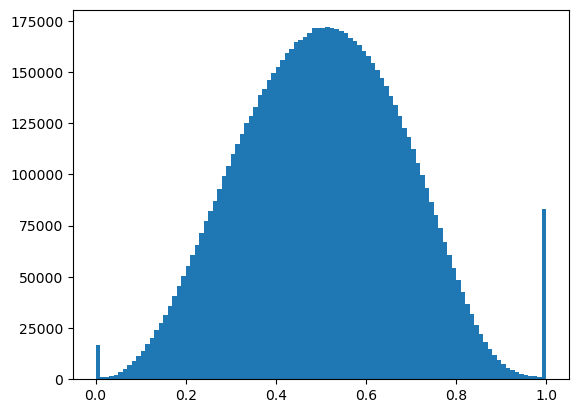

In [148]:
plt.hist(preds, bins=100)
plt.show()

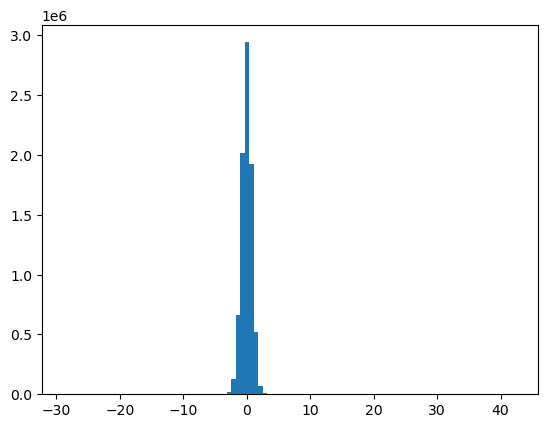

In [149]:
plt.hist(logits, bins=100)
plt.show()

In [51]:
res = tDC.test(dataloader_test, model, loss_fn=nn.BCEWithLogitsLoss, device=device, max_batch_per_epoch=0, paired=config["paired"])

/home/alex/miniconda3/envs/flamingo-3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


Avg test loss: 0.694715	Avg test accuracy: 0.500000



In [158]:
for (x1, x2), *_ in dataset_train:
    if x1.sum() != 101 or x2.sum() != 101:
        break

In [38]:
for dataset in [dataset_train, dataset_valid, dataset_test]:
    print(dataset.n_reads)

61308940
8388608
8388608


In [7]:
with np.load("/home/alex/shared_folder/ChIP_ENCODE/sharded_dataset/test_0.npz") as f:
    print(f['one_hots'].shape)

(1048576, 101, 4)


In [2]:
importlib.reload(models)

<module 'models' from '/home/alex/SCerevisiae_chromatin_NN_prediction/models.py'>

In [3]:
length = 101
model = models.SiameseInceptionNetwork(length)
x1 = torch.tensor(utils.idx_to_onehot(np.random.randint(4, size=(2, length))))
x2 = torch.tensor(utils.idx_to_onehot(np.random.randint(4, size=(2, length))))
x1.shape

torch.Size([2, 101, 4])

In [7]:
pred = model(x1, x2)
pred

tensor([[-0.4993],
        [-0.1610]], grad_fn=<AddmmBackward0>)

In [16]:
weight = torch.tensor([[1], [1]], dtype=float).to(pred.device)
loss_fn = nn.BCEWithLogitsLoss(weight=weight)
loss = loss_fn(pred, torch.tensor([[0], [1]], dtype=float).to(pred.device))
loss

tensor(0.6256, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [2]:
def parse_fastq(filename):
    if filename.endswith("gz"):
        with gzip.open(filename, "rt") as f:
            for read in SeqIO.parse(f, format="fastq"):
                yield read
    else:
        for read in SeqIO.parse(filename, "fastq"):
            yield read

In [15]:
for filename in [
    f"/home/alex/shared_folder/ChIP_ENCODE/random{i}.fastq.gz" for i in range(1, 3)
]:
    with gzip.open(filename, "wt") as f:
        phred = "J" * 101
        seqs = [
            "".join(seq)
            for seq in np.array(list("ACGT"))[
                np.random.randint(4, size=(100000, len(phred)))
            ]
        ]
        for i in range(len(seqs)):
            f.write(f"@read_{i}\n{seqs[i]}\n+\n{phred}\n")

In [85]:
ids, reads = [], []
for read1, read2 in zip(
    parse_fastq("/home/alex/shared_folder/ChIP_ENCODE/random1.fastq.gz"),
    parse_fastq("/home/alex/shared_folder/ChIP_ENCODE/random2.fastq.gz"),
):
    if read1.id != read2.id:
        raise ValueError("Files do not have same ids")
    ids.append(read1.id)
    reads.extend([read1, read2])
maxlen = max(len(read) for read in reads)
minlen = min(len(read) for read in reads)
if minlen != maxlen:
    reads = [read + "N" * (maxlen - len(read)) for read in reads]
reads = np.stack(utils.ordinal_encoder(reads)).reshape(-1, 2, maxlen)
print(reads.shape)
reads[0]

(100000, 2, 101)


array([[2, 2, 2, 0, 3, 0, 2, 2, 1, 3, 0, 3, 2, 3, 1, 3, 3, 2, 2, 3, 1, 2,
        2, 3, 2, 2, 1, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 2, 0, 1, 2, 2, 3, 2,
        1, 2, 2, 1, 0, 2, 1, 1, 3, 3, 3, 2, 2, 1, 1, 0, 0, 2, 3, 0, 2, 3,
        3, 1, 0, 0, 2, 0, 1, 3, 0, 0, 3, 3, 0, 1, 0, 3, 3, 2, 3, 3, 2, 3,
        1, 3, 0, 3, 2, 1, 1, 2, 0, 3, 0, 3, 0],
       [1, 2, 0, 1, 3, 3, 3, 3, 3, 2, 3, 2, 1, 0, 1, 3, 1, 2, 3, 0, 1, 1,
        2, 1, 2, 0, 3, 1, 2, 3, 1, 3, 3, 1, 1, 3, 1, 2, 3, 3, 2, 0, 0, 0,
        0, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 2, 3, 0, 3, 1, 0, 3, 2, 3, 0,
        1, 1, 1, 3, 2, 1, 3, 0, 3, 2, 2, 0, 3, 3, 2, 1, 2, 2, 1, 2, 3, 1,
        3, 1, 0, 3, 2, 0, 1, 2, 0, 1, 3, 3, 2]], dtype=int8)

In [88]:
ids, reads = [], []
for read1, read2 in zip(
    *(
        parse_fastq(filename)
        for filename in (
            "/home/alex/shared_folder/ChIP_ENCODE/random1.fastq.gz",
            "/home/alex/shared_folder/ChIP_ENCODE/random2.fastq.gz",
        )
    )
):
    if read1.id != read2.id:
        raise ValueError("Files do not have same ids")
    ids.append(read1.id)
    reads.extend([read1, read2])
maxlen = max(len(read) for read in reads)
minlen = min(len(read) for read in reads)
if minlen != maxlen:
    reads = [read + "N" * (maxlen - len(read)) for read in reads]
reads = np.stack(utils.ordinal_encoder(reads)).reshape(-1, 2, maxlen)
print(reads.shape)
reads[0]

(100000, 2, 101)


array([[2, 2, 2, 0, 3, 0, 2, 2, 1, 3, 0, 3, 2, 3, 1, 3, 3, 2, 2, 3, 1, 2,
        2, 3, 2, 2, 1, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 2, 0, 1, 2, 2, 3, 2,
        1, 2, 2, 1, 0, 2, 1, 1, 3, 3, 3, 2, 2, 1, 1, 0, 0, 2, 3, 0, 2, 3,
        3, 1, 0, 0, 2, 0, 1, 3, 0, 0, 3, 3, 0, 1, 0, 3, 3, 2, 3, 3, 2, 3,
        1, 3, 0, 3, 2, 1, 1, 2, 0, 3, 0, 3, 0],
       [1, 2, 0, 1, 3, 3, 3, 3, 3, 2, 3, 2, 1, 0, 1, 3, 1, 2, 3, 0, 1, 1,
        2, 1, 2, 0, 3, 1, 2, 3, 1, 3, 3, 1, 1, 3, 1, 2, 3, 3, 2, 0, 0, 0,
        0, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 2, 3, 0, 3, 1, 0, 3, 2, 3, 0,
        1, 1, 1, 3, 2, 1, 3, 0, 3, 2, 2, 0, 3, 3, 2, 1, 2, 2, 1, 2, 3, 1,
        3, 1, 0, 3, 2, 0, 1, 2, 0, 1, 3, 3, 2]], dtype=int8)

In [20]:
lendict = {}
for read in reads:
    if len(read) in lendict:
        lendict[len(read)] += 1
    else:
        lendict[len(read)] = 1
lendict

{101: 100000}

In [ ]:
training_dataRAM = train_pytorch.SequenceDatasetRAM(
    args.fasta_file,
    args.label_files,
    [f"chr{i}" for i in ["I", "II"]],
    winsize=2048,
    head_interval=args.head_interval,
    head_crop=args.head_crop,
    strand=args.strand,
    remove0s=args.remove0s,
    removeNs=args.removeNs,
    transform=utils.idx_to_onehot,
)
train_dataloaderRAM = DataLoader(
    training_dataRAM,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    collate_fn=None,
)

In [5]:
import tempfile
from pathlib import Path
from typing import Callable, List, Tuple

import pyBigWig as pbw
from scipy.signal import convolve
from torch.utils.data import DataLoader, Dataset
import train_DeepChIP

In [142]:
# def get_indices_by_file(self, indices):
#     """Group indices by files they fall into, and change to indices from file start."""
#     file_idx, idx_mod = divmod(indices, self.shard_size)
#     return {i: idx_mod[file_idx == i] for i in range(4)}

# def read_with_mmap(self, indices):
#     """Get reads associated to indices."""
#     # Group indices by files
#     indices_by_file = self.get_indices_by_file(indices)
#     reads = []
#     for i, length in enumerate(self.file_lengths):
#         # Use memmap to load specific indices
#         reads.append(
#             np.memmap(
#                 Path(self.dirname, f"{self.split}_{i}.npy"),
#                 dtype=self.dtype,
#                 shape=(length,) + self.read_shape,
#                 mode="r",
#                 offset=128,
#             )[indices_by_file[i]]
#         )
#     return np.concatenate(reads)

In [10]:
dataset_dir = "paired_sharded_dataset"
num_workers = 1
paired = True
balance_classes = False
batch_size = 1024
training_data = train_DeepChIP.DatasetFromFiles(
    dataset_dir,
    split='train',
    strand='for',
    transform=utils.idx_to_onehot,
)
valid_data = train_DeepChIP.DatasetFromFiles(
    dataset_dir,
    split='valid',
    strand='for',
    transform=utils.idx_to_onehot,
    paired=paired
)
if balance_classes:
    def collate_fn(batch):
        return train_DeepChIP.collate_classbalance(batch)
else:
    collate_fn = None
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

In [12]:
import time

In [17]:
t0 = time.time()
for i, (X, y, w) in enumerate(train_dataloader):
    print(len(X))
    print(X[0].shape)
    print(X[0])
    print(time.time() - t0)
    break

2
torch.Size([1024, 101, 4])
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        ...,

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0.,

In [4]:
dataset = train_DeepChIP.DatasetFromFiles("paired_sharded_dataset", "train")
len(dataset)

61308940

In [5]:
(x1, x2), y, w = dataset[0]
print(x1.shape, x2.shape, y, w)

(101, 4) (101, 4) 1 1


In [7]:
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=4)

In [15]:
import pandas as pd

/tmp/ipykernel_1876179/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
batch_size = 1024
label = np.random.randint(2, size=batch_size) != 0
weight = 1.5 + np.random.random(size=batch_size)

new_weight.sum(), weight.sum()

(1061.4660887842454, 2052.456451496042)

In [51]:
def sum_byclass1(label, weight):
    dico = {}
    for lab, w in zip(label, weight):
        if lab in dico: dico[lab] += w
        else: dico[lab] = w
    return dico

def sum_byclass2(label, weight):
    return {lab: np.sum(weight[label == lab]) for lab in np.unique(label)}

def sum_byclass3(label, weight):
    df = pd.DataFrame({"label": label, "weight": weight})
    return df.groupby("label").sum()

def sum_byclass4(label, weight):
    y = label
    tot = np.size(weight)
    tot_pos = np.sum(np.where(y, weight, 0))
    tot_neg = np.sum(np.where(y, weight, 0))
    return np.where(
        y,
        weight*tot / (2*tot_pos),
        weight*tot / (2*tot_neg)
    )

In [25]:
batch_size = 1024
label = np.random.randint(10, size=batch_size)
weight = .5 + np.random.random(size=batch_size)
%timeit sum_byclass1(label, weight)
%timeit sum_byclass2(label, weight)
%timeit sum_byclass3(label, weight)

208 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
82.5 µs ± 535 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
515 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [52]:
batch_size = 1024
label = np.random.randint(2, size=batch_size) != 0
weight = .5 + np.random.random(size=batch_size)
%timeit sum_byclass1(label, weight)
%timeit sum_byclass2(label, weight)
%timeit sum_byclass3(label, weight)
%timeit sum_byclass4(label, weight)

130 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
25 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
501 µs ± 999 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
18.9 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
batch_size = 1024*10
label = np.random.randint(2, size=batch_size) != 0
weight = .5 + np.random.random(size=batch_size)
%timeit sum_byclass1(label, weight)
%timeit sum_byclass2(label, weight)
%timeit sum_byclass3(label, weight)

1.24 ms ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
181 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
605 µs ± 897 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
batch_size = 1024*100
label = np.random.randint(2, size=batch_size) != 0
weight = .5 + np.random.random(size=batch_size)
%timeit sum_byclass1(label, weight)
%timeit sum_byclass2(label, weight)
%timeit sum_byclass3(label, weight)

12.5 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.73 ms ± 4.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.42 ms ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
import time

In [9]:
t0 = time.time()
for i, ((x1, x2), y, w) in enumerate(dataloader):
    if i % 100 == 0:
        print(i, time.time() - t0)
    if i > 500:
        break

0 0.0890798568725586
100 0.544684648513794
200 0.9197783470153809
300 1.2938051223754883
400 1.6689815521240234
500 2.1042237281799316


In [2]:
from pathlib import Path

In [ ]:
def get_indices_by_file(indices, shard_size):
    file_idx, idx_mod = divmod(indices, shard_size)
    return {i: idx_mod[file_idx == i] for i in range(4)}


def read_with_mmap(indices):
    split = "train"
    dataset = "paired_sharded_dataset"
    n_files = 4
    shard_size = 2**24
    last_shard_size = 10_977_292
    shape = (shard_size, 2, 101)
    dtype = np.int8
    indices_by_file = get_indices_by_file(indices, shard_size)
    reads = []
    for i, shard_size in enumerate([shard_size] * (n_files - 1) + [last_shard_size]):
        reads.append(
            np.memmap(
                Path(dataset, f"{split}_{i}.npy"),
                dtype=dtype,
                shape=(shard_size,) + shape[1:],
                mode="r",
                offset=128,
            )[indices_by_file[i]]
        )
    return np.concatenate(reads)

In [78]:
for file in Path("paired_sharded_dataset").glob("*.npz"):
    npyfile = Path(file.parent, file.stem + ".npy")
    if not npyfile.exists():
        print(f"writing {npyfile}")
        with np.load(file) as f:
            np.save(npyfile, f["reads"])

writing paired_sharded_dataset/train_3.npy
writing paired_sharded_dataset/train_0.npy
writing paired_sharded_dataset/train_2.npy
writing paired_sharded_dataset/valid_0.npy
writing paired_sharded_dataset/train_1.npy


In [90]:
%timeit reads = np.load("paired_sharded_dataset/test_0.npy")
%timeit reads = np.load("paired_sharded_dataset/train_0.npy")
%timeit reads = np.memmap("paired_sharded_dataset/test_0.npy", dtype='int8', shape=(2**23, 2, 101), mode='r', offset=128)
%timeit reads = np.memmap("paired_sharded_dataset/train_0.npy", dtype='int8', shape=(2**24, 2, 101), mode='r', offset=128)

242 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
506 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.7 µs ± 368 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
19.5 µs ± 398 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
train_shards = []
for i in range(3):
    train_shards.append(np.load(f"paired_sharded_dataset/train_{i}.npy"))
train_shard = np.concatenate(train_shards, axis=0)
train_shard.shape

(50331648, 2, 101)

In [101]:
indices = np.random.randint(2**24, size=1024)
while len(np.unique(indices)) != len(indices):
    indices = np.random.randint(2**24, size=1024)
indices

array([ 1412229,  7234354, 11941675, ..., 15862277,  1245288, 10982186])

In [104]:
%timeit reads = np.load("paired_sharded_dataset/test_0.npy")[indices]
%timeit reads = np.load("paired_sharded_dataset/train_0.npy")[indices]
%timeit reads = np.memmap("paired_sharded_dataset/test_0.npy", dtype='int8', shape=(2**23, 2, 101), mode='r', offset=128)[indices]
%timeit reads = np.memmap("paired_sharded_dataset/train_0.npy", dtype='int8', shape=(2**24, 2, 101), mode='r', offset=128)[indices]

256 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
533 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.84 ms ± 8.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.09 ms ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [102]:
def loop_mmap():
    reads = []
    for idx in indices:
        reads.append(
            np.memmap(
                "paired_sharded_dataset/train_0.npy",
                dtype="int8",
                shape=(2**24, 2, 101),
                mode="r",
                offset=128,
            )[idx]
        )
    return np.concatenate(reads)


def single_mmap():
    return np.memmap(
        "paired_sharded_dataset/train_0.npy",
        dtype="int8",
        shape=(2**24, 2, 101),
        mode="r",
        offset=128,
    )[indices]

In [103]:
%timeit loop_mmap()
%timeit single_mmap()

27.3 ms ± 67.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.18 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
indices_by_file = get_indices_by_file(indices, 2**24)

In [77]:
arr = np.random.random(1000).astype("float32")
np.save("float32.npy", arr)

In [80]:
arr[:10]

array([0.39248276, 0.40912217, 0.44340226, 0.80827844, 0.31452698,
       0.53480494, 0.2300319 , 0.21574275, 0.6069011 , 0.43160114],
      dtype=float32)

In [82]:
np.memmap("float32.npy", dtype="float32", mode="r", offset=128)[:10]

memmap([0.39248276, 0.40912217, 0.44340226, 0.80827844, 0.31452698,
        0.53480494, 0.2300319 , 0.21574275, 0.6069011 , 0.43160114],
       dtype=float32)

In [60]:
reads = read_with_load()
reads_mmap = read_with_memmap(indices)
reads.shape, reads_mmap.shape

((1024, 2, 101), (1024, 2, 101))

In [71]:
reads_mmap = read_with_memmap(indices)

In [72]:
np.all(reads == reads_mmap)

True

In [52]:
%timeit read_with_load()
%timeit read_with_memmap()

1.89 s ± 792 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.4 ms ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
train0 = np.load("paired_sharded_dataset/train_0.npy")
train3 = np.load("paired_sharded_dataset/train_3.npy")

In [11]:
train3.dtype, train3.shape

(dtype('int8'), (10977292, 2, 101))

In [3]:
mmap_train0 = np.memmap(
    "paired_sharded_dataset/train_0.npy",
    dtype="int8",
    shape=(2**24, 2, 101),
    mode="r",
    offset=128,
)
mmap_train1 = np.memmap(
    "paired_sharded_dataset/train_1.npy",
    dtype="int8",
    shape=(2**24, 2, 101),
    mode="r",
    offset=128,
)
mmap_train2 = np.memmap(
    "paired_sharded_dataset/train_2.npy",
    dtype="int8",
    shape=(2**24, 2, 101),
    mode="r",
    offset=128,
)
mmap_train3 = np.memmap(
    "paired_sharded_dataset/train_3.npy",
    dtype="int8",
    shape=(10_977_292, 2, 101),
    mode="r",
    offset=128,
)

In [24]:
mmap_train3.dtype, mmap_train3.shape

(dtype('int8'), (10977292, 2, 101))

In [25]:
np.all(mmap_train3 == train3)

True

In [6]:
print(train3)

NameError: name 'train3' is not defined

In [5]:
print(mmap_train3)

[[[2 1 1 ... 0 3 2]
  [1 1 1 ... 1 0 3]]

 [[1 3 2 ... 1 3 2]
  [0 0 2 ... 1 1 0]]

 [[0 3 3 ... 1 0 1]
  [3 2 2 ... 0 0 3]]

 ...

 [[2 2 0 ... 2 3 2]
  [2 3 0 ... 0 1 1]]

 [[1 0 3 ... 1 0 2]
  [1 0 0 ... 0 1 3]]

 [[0 2 2 ... 2 0 1]
  [1 3 2 ... 1 1 3]]]
